# validating tsinfer/tsdate tree sequence inference. 
## test 1: contemporaneous tips + recombination

This notebook is a continuation of mvr.ipynb. Previously, I perform topological inference (tsinfer) and internal node dating (tsdate) using the proxy method and varying parameters: recombination_rate AND mismatch_ratio. 

I will use variation of information criterion to understand how well tsinfer reconstructs recombination breakpoints (number and location). 

### import modules

In [77]:
import tsinfer
import tskit
import msprime
import tsdate
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LinearRegression
from itertools import combinations
import seaborn as sns

### simulate ancestry
I use msprime to simulate a geneology of 25 individuals sampled contemporaneously at time = 0 with a fixed recombination rate. 

In [78]:
ts = msprime.sim_ancestry(
    samples = [
        msprime.SampleSet(25, time=0, ploidy = 1),
        #msprime.SampleSet(10, time=10, ploidy = 1),
        #msprime.SampleSet(5, time=50, ploidy = 1)
    ],
    ploidy = 1, 
    sequence_length=1e6,
    random_seed=50,
    recombination_rate=1e-6
)

### simulate mutations onto geneology 
I set a mutation rate onto the geneology. (Note: if I apply too low of a mutation rate, sampled genomes end up being too similar and tsinfer fails to reconstruct topology accurately.) 

In [79]:
ts = msprime.sim_mutations(ts, rate = 3e-5, random_seed = 42) 

The final simulated tree sequence contains 6 trees (i.e. 5 recombination breakpoints) and 256 mutations. 

In [80]:
ts

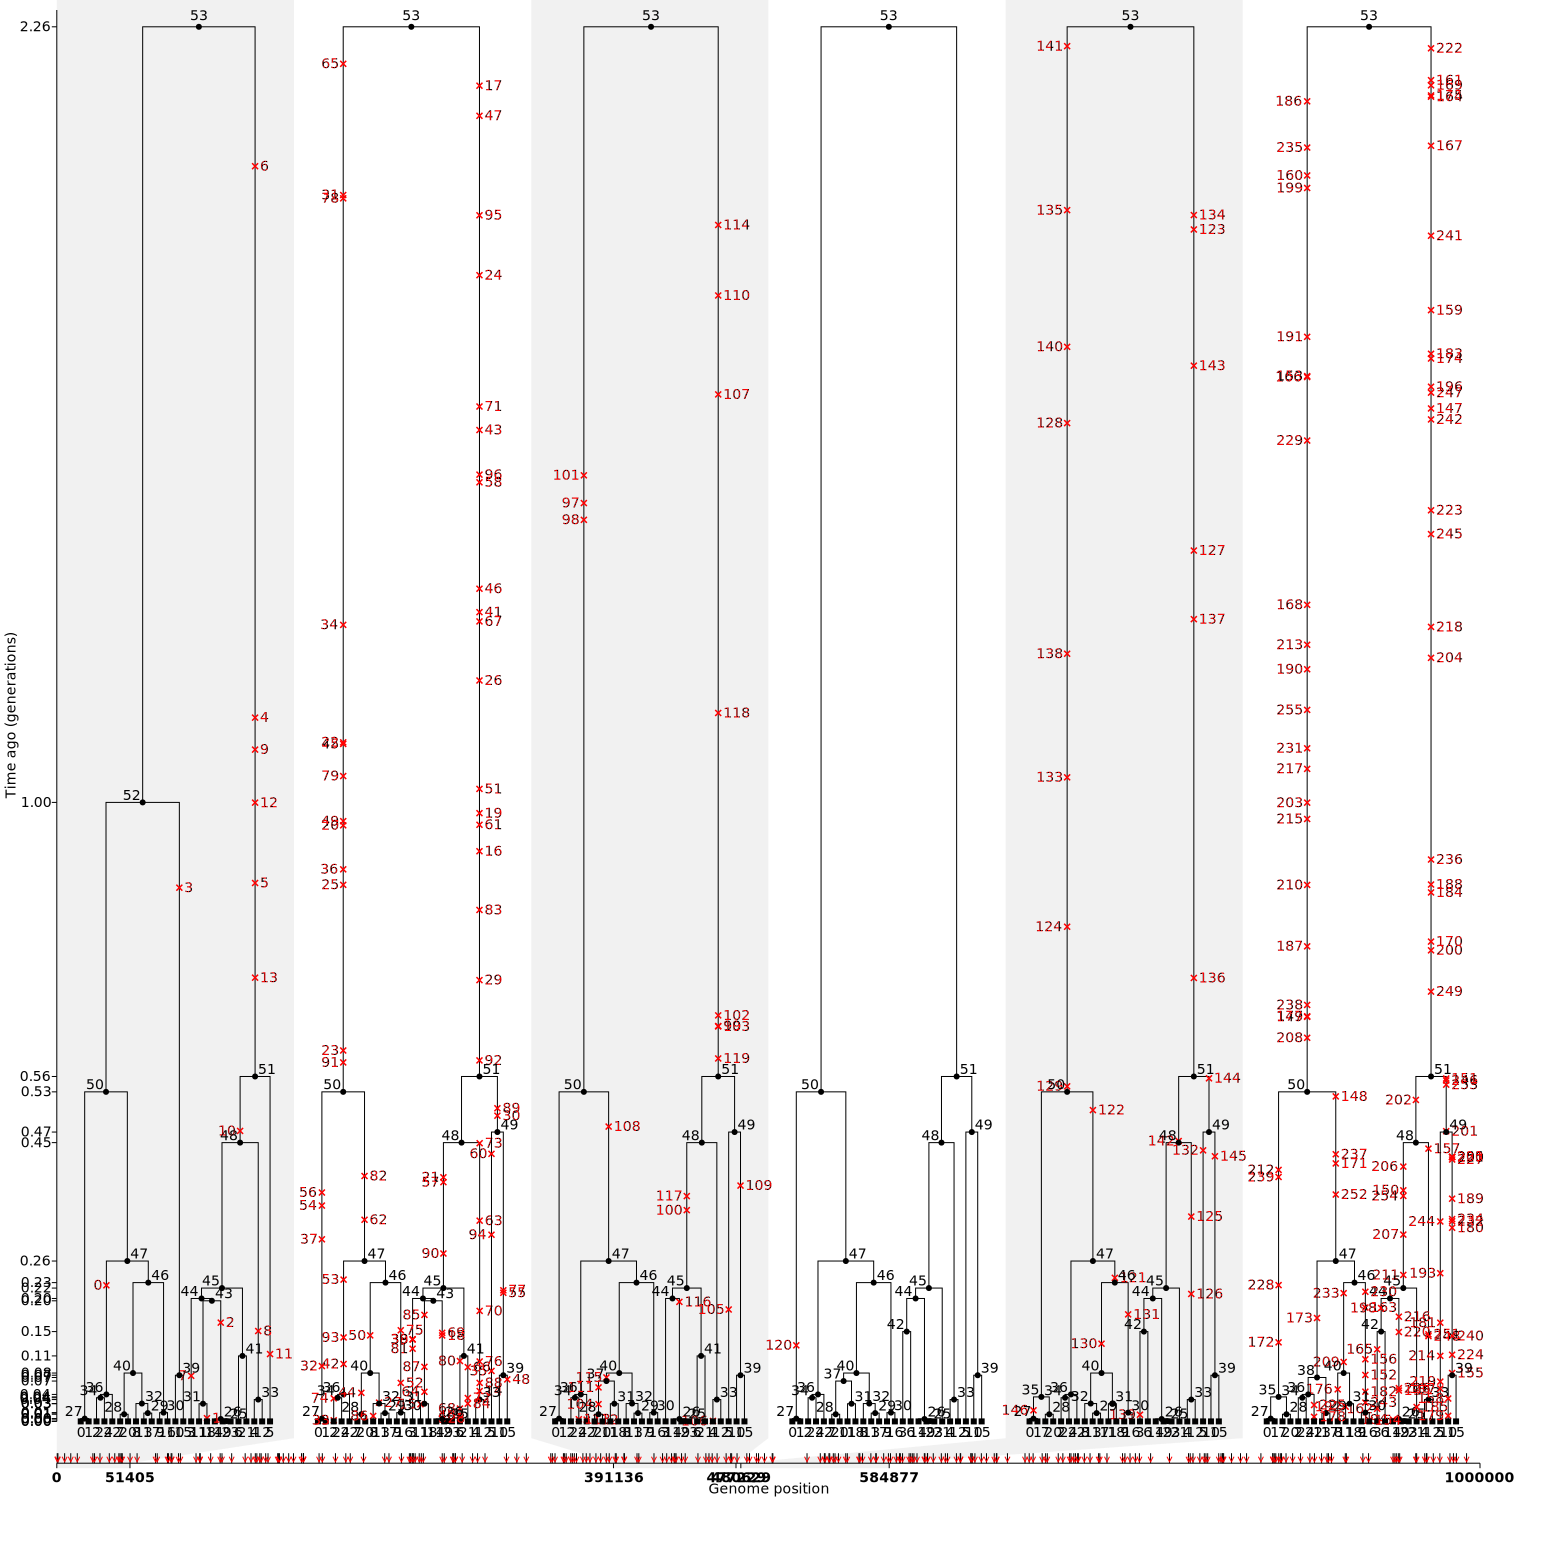

In [81]:
ts.draw_svg(size=(1500, 1500),
 canvas_size=(1550, 1550),
         y_axis=True
        )

### date internal nodes of simulated tree sequence

In [82]:
sampling_times = ts.nodes_time[0:25]

In [83]:
dated_ts = tsdate.date(ts, 
                       mutation_rate=3e-5, # same mutation rate used for simulation 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True
                       )



In [84]:
# integer value assigned to each individual in the tree. used for indexing purposes later on. 
samples = list(dated_ts.samples())

### export as vcf and import as vcz
Tsinfer can only read in VCZ files. I export the geneology as a VCF, translate to VCZ (bio2zarr), then reimport.

In [85]:
# with open(f"../../data/present_sim.vcf", "w") as fh: 
#     ts.write_vcf(output = fh)

In [86]:
# get ancestral states
ancestral_states = []

for site in ts.sites():
    if site.ancestral_state is None:
        ancestral_states.append("N")
        #print("N")
    else:
        ancestral_states.append(str(site.ancestral_state))
        #print(site.ancestral_state)

ancestral_states = np.array(ancestral_states)

Creating vdata object 

In [87]:
vdata = tsinfer.VariantData("../data/vcz_files/present.vcz/",
                            ancestral_state=ancestral_states,
                           individuals_time=sampling_times)

## run inference
Reinfers the topological/temporal structure of the simulated tree sequences under varying rr (recombination rate) and mm (mismatch ratio). Called by rr_mm() and rr() functions. Returns rr and mm value used to produce tree sequence, as well as the dated simulated tree sequence. 

In [88]:
def run_inference2(vdata, rr_value = None, mm_value = None): 
    
    if rr_value != None:
        rr = rr_value 
        mm = mm_value
    else: 
        rr = None
        mm = None
        

    anc = tsinfer.generate_ancestors(vdata)
    anc_ts = tsinfer.match_ancestors(vdata, anc, recombination_rate = rr, mismatch_ratio = mm)
    ts = tsinfer.match_samples(vdata, anc_ts, recombination_rate = rr)
    simplified_ts = tsdate.preprocess_ts(ts, erase_flanks=False)

    dated_ts = tsdate.date(simplified_ts, 
                       mutation_rate=3e-5, 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True,
                       #rescaling_intervals = 492
                       )
    
    return rr, mm, dated_ts
     

### get tree width

In [89]:
def get_intervals(dated_ts): 

    data = []
    
    for tree in dated_ts.trees():
        left, right = tree.interval
        data.append({
            "tree_index": tree.index,
            "left": left,
            "right": right,
        })
    
    intervals = pd.DataFrame(data)

    return intervals


### get mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the simulated tree sequence.

In [90]:
def sims_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(0, dated_ts.get_num_trees()):
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the inferred tree sequence.

In [91]:
def res_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(1, dated_ts.get_num_trees()-1): #flanking trees are not informative and must be trimmed
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

In [92]:
# def lg(mrcas):
#     X = mrcas["proxy"].values.reshape(-1, 1)
#     y = mrcas["sim"].values
#     weights = mrcas["width"]/1e6
#     reg = LinearRegression().fit(X, y, weights)
#     return X, y, reg, weights


### varying recombination rate and mismatch_ratio during inference

Produces an array of recombination rates and mismatch ratios , then calls run_inference to infer tree sequences under varying parameters. Returns counts (for indexing), metadata (tree index, rr and mm values), and seqs(a list of tree sequences). 

In [93]:
def rr_mm(vdata): 
    
    rates = [10**x for x in range(-8, 0, 1)]
    rates.append(None)

    mms = [10**x for x in range(-3, 1, 1)]
    #mms.append(None) 
    
    grid_num_trees = np.zeros(shape=(11, 4))
    seqs = [] #save each ts here 
    
    count = 0
    nones = 0

    metadata = [] 
    counts = []
    for rr_idx, rr_value in enumerate(rates):
        for mm_idx, mm_value in enumerate(mms): 

            if nones > 0: 
                break

            if rr_value == None:
                mm_value = 1
                nones += 1 
            
            count+=1
            
            rr, mm, ip = run_inference2(vdata, rr_value, mm_value)
            
            grid_num_trees[rr_idx][mm_idx] = ip.num_trees
            
            seqs.append(ip) 

            metadata.append({"index": count-1, "rate": rr, "mm": mm})

            counts.append({"rate": rr, "mm": mm, "num_trees": ip.num_trees}) 

            print(f"Finished inference {count}/{len(rates)}. RR: {rr_value}, MM: {mm_value}, num trees: {ip.num_trees}")

    return pd.DataFrame(counts), pd.DataFrame(metadata), seqs 


### run inference

Here, I run rr_mm which produces N tree sequences with varying numbers of recombination breakpoints. 

In [94]:
counts, metadata, seqs = rr_mm(vdata)

Finished inference 1/9. RR: 1e-08, MM: 0.001, num trees: 11
Finished inference 2/9. RR: 1e-08, MM: 0.01, num trees: 11
Finished inference 3/9. RR: 1e-08, MM: 0.1, num trees: 11
Finished inference 4/9. RR: 1e-08, MM: 1, num trees: 8
Finished inference 5/9. RR: 1e-07, MM: 0.001, num trees: 11
Finished inference 6/9. RR: 1e-07, MM: 0.01, num trees: 11
Finished inference 7/9. RR: 1e-07, MM: 0.1, num trees: 11
Finished inference 8/9. RR: 1e-07, MM: 1, num trees: 8
Finished inference 9/9. RR: 1e-06, MM: 0.001, num trees: 11
Finished inference 10/9. RR: 1e-06, MM: 0.01, num trees: 11
Finished inference 11/9. RR: 1e-06, MM: 0.1, num trees: 11
Finished inference 12/9. RR: 1e-06, MM: 1, num trees: 8
Finished inference 13/9. RR: 1e-05, MM: 0.001, num trees: 11
Finished inference 14/9. RR: 1e-05, MM: 0.01, num trees: 11
Finished inference 15/9. RR: 1e-05, MM: 0.1, num trees: 11
Finished inference 16/9. RR: 1e-05, MM: 1, num trees: 8
Finished inference 17/9. RR: 0.0001, MM: 0.001, num trees: 12
Fin

#### get mrca dfs for simulated tree

In [95]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [96]:
sim_list = sims_times(dated_ts, samples) 

#### get mrca dfs for each tree (w/ varying mm)

In [97]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [98]:
mms = [10**x for x in range(-3, 1, 1)]
#mms.append(None)

In [99]:
res_list = []

for id, ts in enumerate(seqs): 
    df = res_times(ts, samples)
    df['rr'] = str(metadata[metadata.index==id].rate.iloc[0]) ###  
    df['mm'] = str(metadata[metadata.index==id].mm.iloc[0]) #### 
    res_list.append(df) 

# Analysis

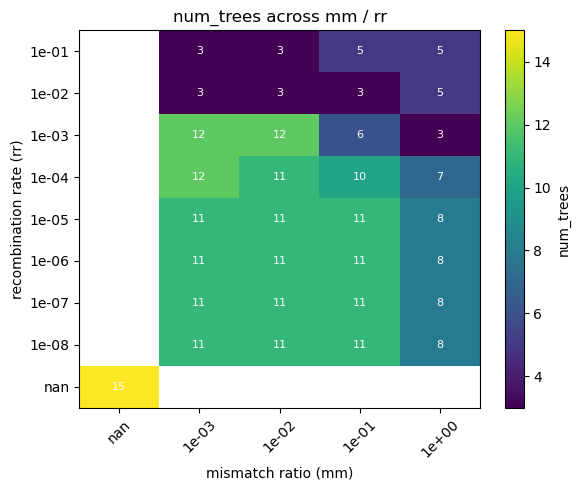

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = counts.copy()

# replace NAs with string
df["rr"] = df["rate"].astype(float)
df["mm"] = df["mm"].apply(lambda x: "nan" if pd.isna(x) else float(x))

# rows = rr (Y), columns = mm (X)
pivot_trees = df.pivot(index="rr", columns="mm", values="num_trees")

# sort axes so NAs are first 
cols = pivot_trees.columns.tolist()
cols_sorted = ["nan"] if "nan" in cols else []
cols_sorted += sorted([c for c in cols if c != "nan"], key=lambda x: float(x))
pivot_trees = pivot_trees[cols_sorted]
pivot_trees = pivot_trees.sort_index(ascending=False)

# plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(pivot_trees.values, aspect='auto', cmap='viridis')

# annotate cells with num_trees
for i in range(pivot_trees.shape[0]):
    for j in range(pivot_trees.shape[1]):
        val = pivot_trees.iloc[i, j]
        if not np.isnan(val):
            plt.text(j, i, int(val), ha='center', va='center', color='white', fontsize=8)

# colorbar and ticks
plt.colorbar(im, label='num_trees')
plt.xticks(
    range(len(pivot_trees.columns)),
    [str(c) if c == "nan" else f"{float(c):.0e}" for c in pivot_trees.columns],
    rotation=45
)
plt.yticks(
    range(len(pivot_trees.index)),
    [f"{float(y):.0e}" for y in pivot_trees.index]
)

# labeling
plt.xlabel('mismatch ratio (mm)')
plt.ylabel('recombination rate (rr)')
plt.title('num_trees across mm / rr')
plt.tight_layout()
plt.show()


# variation of information criterion

### get segments

In [109]:
def get_segments(df): 
    seg = (df.drop_duplicates('index').sort_values('left')[['left','right']].to_numpy(float)) # lefts and rights
    return seg

In [196]:
get_segments(sim_list)

array([[      0.,   51405.],
       [  51405.,  391136.],
       [ 391136.,  477229.],
       [ 477229.,  480629.],
       [ 480629.,  584877.],
       [ 584877., 1000000.]])

##### export segments

In [113]:
segments = []
segments.append(get_segments(sim_list)) 
for i in range(32):
    segments.append(get_segments(res_list[i]))

In [114]:
# with open("segments.txt", "w") as file:
#     for item in segments:
#         file.write(f"{item}\n")

### get coordinates 

In [110]:
def get_coordinates(seg):
    bps = seg[:-1, 1]  # right edges except the last
    bps = np.concatenate(([seg[0,0]], bps, [seg[-1,1]]))
    return bps

In [116]:
get_coordinates(get_segments(sim_list))

array([      0.,   51405.,  391136.,  477229.,  480629.,  584877.,
       1000000.])

### compute overlap
Returns M[i,j] matrix of base pair overlap for every sim[i] and inf[j] 

In [117]:
def get_overlap(seg1, seg2): 
    m, n = len(seg1), len(seg2) # get length m of sim_seg, n of inf_seg
    M = np.zeros((m, n), float) # matrix size m x n 
    
    i = 0 # sim counter
    j = 0 # inf counter 
    
    while i < m and j < n: # iterate through segments 
        
        # get overlap interval 
        L = max(seg1[i,0], seg2[j,0]) # from max(left coordinate)
        R = min(seg1[i,1], seg2[j,1]) # to min(right coordinate) 
        if R > L: # if right coordinate is larger than left coordinate, the segments overlap
            M[i,j] += (R - L)  # add overlap length to M[i,j] 

        # increase counter for segment which ends earlier
        if seg1[i,1] <= seg2[j,1]:  
            i += 1
        else: j += 1
            
    return M # M[i,j] matrix of base pair overlap for every sim[i] and inf[j] 

### normalized [variation of information](https://en.wikipedia.org/wiki/Variation_of_information) between segments
##### VI = H(sim)+H(inf)−2·I(sim,inf))

VI = sum(entropies) - 2 * mutual information 

In [152]:
def compute_vi(M):
    L = M.sum()  # total covered genome length 

    # translate genome coverage into probabilities 
    p = M.sum(axis=1) / L # p[i] = fraction of the genome covered by sim segment i
    q = M.sum(axis=0) / L # q[j] = fraction of the genome covered by inf segment j
    r = M / L # fraction of genome covered by overlap of sim[i] and inf[j]  

    # compute entropies 
    Hx = -np.nansum(p * np.log(p, where=p>0)) 
    Hy = -np.nansum(q * np.log(q, where=q>0))
    
    # compute mutual information between sim and inf 
    # sum r_ij * log( r_ij / (p_i * q_j) )
    denom = p[:, None] * q[None, :] # (p_i * q_j)
    mask = (r > 0) & (denom > 0) # avoid dividing by zero 
    I = np.sum(r[mask] * np.log(r[mask] / denom[mask]))

    # compute variation of information 
    denom_norm = Hx + Hy # denominator for normalizing 
    if denom_norm > 0:  
        VI = float((Hx + Hy - 2.0 * I) / denom_norm)
    else: 
        VI = 0.0 
        
    return  VI

### compute

In [182]:
res = [] 
sim = get_segments(sim_list)

for index in range(33):
    inf = get_segments(res_list[index])
    M = get_overlap(sim, inf) 
    res.append(compute_vi(M))

res = pd.DataFrame(res)

### visualize

In [189]:
vi_df = metadata.copy()
vi_df.drop('index', axis=1, inplace=True)
vi_df['vi'] = res

In [191]:
vi_df["rate"] = vi_df["rate"].astype(float)
vi_df["mm"] = vi_df["mm"].apply(lambda x: "nan" if pd.isna(x) else float(x))

# rows = rr (Y), columns = mm (X); sort axes so NAs are first 
pivot_vi = vi_df.pivot(index="rate", columns="mm", values="vi")
cols = pivot_vi.columns.tolist()
cols_sorted = ["nan"] if "nan" in cols else []
cols_sorted += sorted([c for c in cols if c != "nan"], key=lambda x: float(x))
pivot_vi = pivot_vi[cols_sorted]
pivot_vi = pivot_vi.sort_index(ascending=False)

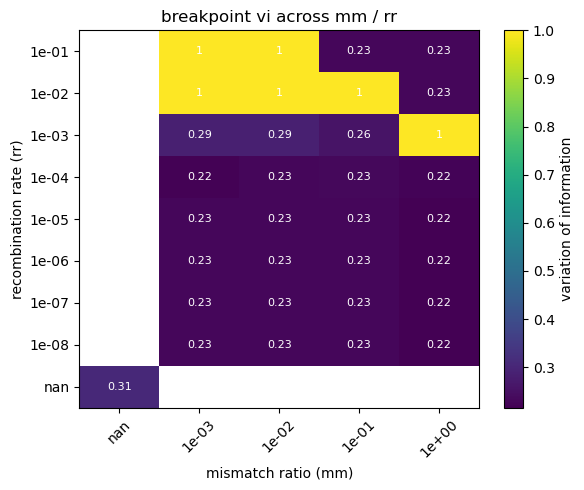

In [195]:
pivot_df = pivot_vi
plt.figure(figsize=(6, 5))
im = plt.imshow(pivot_df.values, aspect='auto', cmap='viridis')

# annotate each non-NaN cell with the metric value
for i in range(pivot_df.shape[0]):
    for j in range(pivot_df.shape[1]):
        val = pivot_df.iloc[i, j]
        if not (isinstance(val, float) and np.isnan(val)):
            plt.text(j, i, "{:.2g}".format(val), ha='center', va='center',
                     color='white', fontsize=8)

# colorbar, ticks
plt.colorbar(im, label='variation of information')

# scientific fmt for ticks
xlabels = []
for c in pivot_df.columns:
    try:
        xlabels.append(f"{float(c):.0e}")
    except Exception:
        xlabels.append(str(c))
ylabels = []
for r in pivot_df.index:
    try:
        ylabels.append(f"{float(r):.0e}")
    except Exception:
        ylabels.append(str(r))

plt.xticks(range(len(pivot_df.columns)), xlabels, rotation=45)
plt.yticks(range(len(pivot_df.index)), ylabels)

# labels & title
plt.xlabel('mismatch ratio (mm)')
plt.ylabel('recombination rate (rr)')
plt.title("breakpoint vi across mm / rr")
plt.tight_layout()
plt.show()